In [1]:
#importlar edirik
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pandas.tseries.offsets import DateOffset

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#data 1 list oxuyuruq.
df1=pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2009-2010')

In [3]:
df1.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
#ölçü
df1.shape

(525461, 8)

In [5]:
#datanın 2-ci listinin oxunuşu
df2=pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2010-2011')

In [6]:
df2.shape

(541910, 8)

In [7]:
#concat metodundan istifadə etməklə 2 ayrı listi bir df adlı data formasında birləşdiririk
df=pd.concat([df1,df2], axis=0)

In [8]:
#null value-lərin toplamı
df1.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [9]:
df2.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [10]:
#bizim analiz və modelimizdə istifadə edilməyəcək sütunları silirik
df.drop(["Description",'Customer ID'], inplace=True, axis=1)

In [11]:
#ölkələr üzrə satış sayları
top_countries = df['Country'].value_counts().head(10)
print("En çox satiş edilen ölkeler:\n", top_countries)


En çox satiş edilen ölkeler:
 Country
United Kingdom    981330
EIRE               17866
Germany            17624
France             14330
Netherlands         5140
Spain               3811
Switzerland         3189
Belgium             3123
Portugal            2620
Australia           1913
Name: count, dtype: int64


In [12]:
#yekun df datamızın statistik təsviri
df.describe()

,Quantity,InvoiceDate,Price
count,1.067371e+06,1067371,1.067371e+06
mean,9.938898e+00,2011-01-02 21:13:55.394028544,4.649388e+00
min,-8.099500e+04,2009-12-01 07:45:00,-5.359436e+04
25%,1.000000e+00,2010-07-09 09:46:00,1.250000e+00
50%,3.000000e+00,2010-12-07 15:28:00,2.100000e+00
75%,1.000000e+01,2011-07-22 10:23:00,4.150000e+00
max,8.099500e+04,2011-12-09 12:50:00,3.897000e+04
std,1.727058e+02,NaN,1.235531e+02


In [13]:
#dəyişkənlərin tipi
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1067371 entries, 0 to 541909
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Quantity     1067371 non-null  int64         
 3   InvoiceDate  1067371 non-null  datetime64[ns]
 4   Price        1067371 non-null  float64       
 5   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 57.0+ MB


In [14]:
#datani standart dagilima getirmek üçün istifadə edilən sinif metodu
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()



In [15]:
#Standart scale metodu ilə datada int ve float tip olan sütunları çevirmək üçün istifadə olunur.
for column in df.columns:
    if df[column].dtype in ['int64', 'float64']:
        df[column] = scale.fit_transform(df[column].values.reshape(-1,1))

In [16]:
df.head()

,Invoice,StockCode,Quantity,InvoiceDate,Price,Country
0,489434,85048,0.011934,2009-12-01 07:45:00,0.018620,United Kingdom
1,489434,79323P,0.011934,2009-12-01 07:45:00,0.017002,United Kingdom
2,489434,79323W,0.011934,2009-12-01 07:45:00,0.017002,United Kingdom
3,489434,22041,0.220381,2009-12-01 07:45:00,-0.020634,United Kingdom
4,489434,21232,0.081417,2009-12-01 07:45:00,-0.027514,United Kingdom


In [17]:
df.shape

(1067371, 6)

In [18]:
#yekun datada təkrarlanmalar saymaq 
df.duplicated().sum()

34337

In [19]:
#yekun datada təkrarlanmalar silmək 
df.drop_duplicates(inplace=True)

In [20]:
df.duplicated().sum()

0

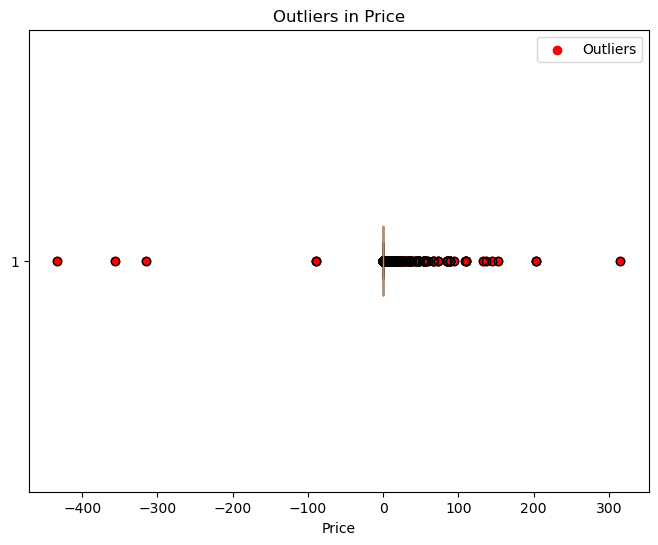

In [21]:
# Boxplot qrafiki ve outlier 
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.boxplot(df['Price'], vert=False)
q1 = df['Price'].quantile(0.25)
q2 = df['Price'].quantile(0.5)
q3 = df['Price'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = df[(df['Price'] < lower_bound) | (df['Price'] > upper_bound)]
plt.scatter(outliers['Price'], [1] * len(outliers), color='red', label='Outliers')
plt.legend()
plt.xlabel('Price')
plt.title('Outliers in Price')
plt.show()


In [22]:
#outlierleri fillna metodu ile mean() ile doldurma
df['Quantity'] = df['Quantity'].fillna(df['Quantity'].mean())
df['Price'] = df['Price'].fillna(df['Price'].mean())


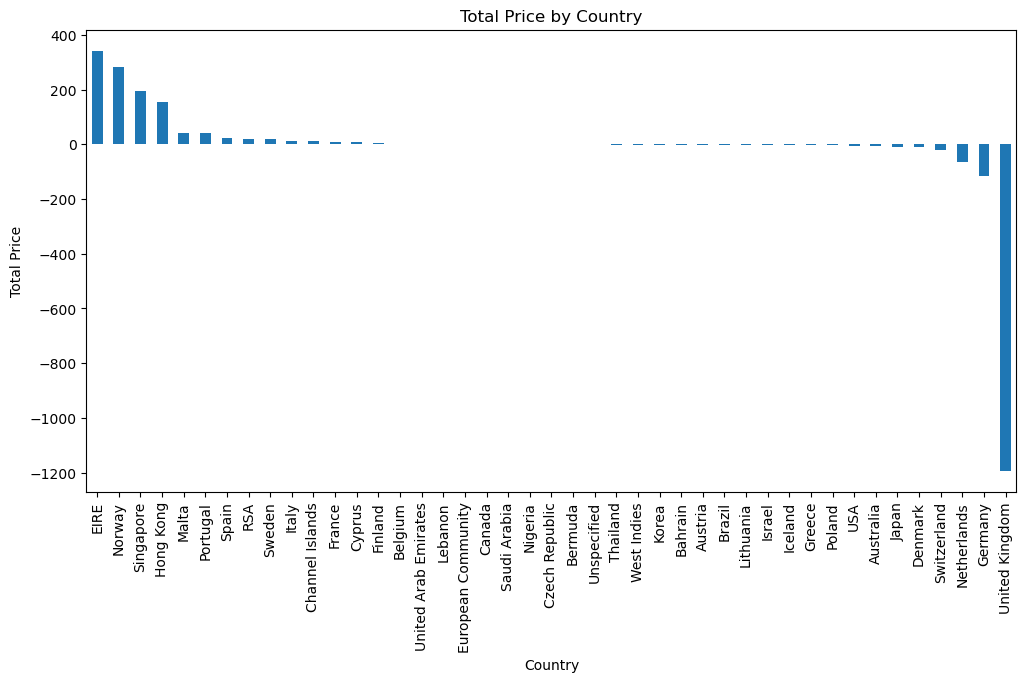

In [23]:
# Her bir ölkənin toplam price hesablama ve grafik
country_prices = df.groupby('Country')['Price'].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
country_prices.plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Total Price')
plt.title('Total Price by Country')
plt.show()


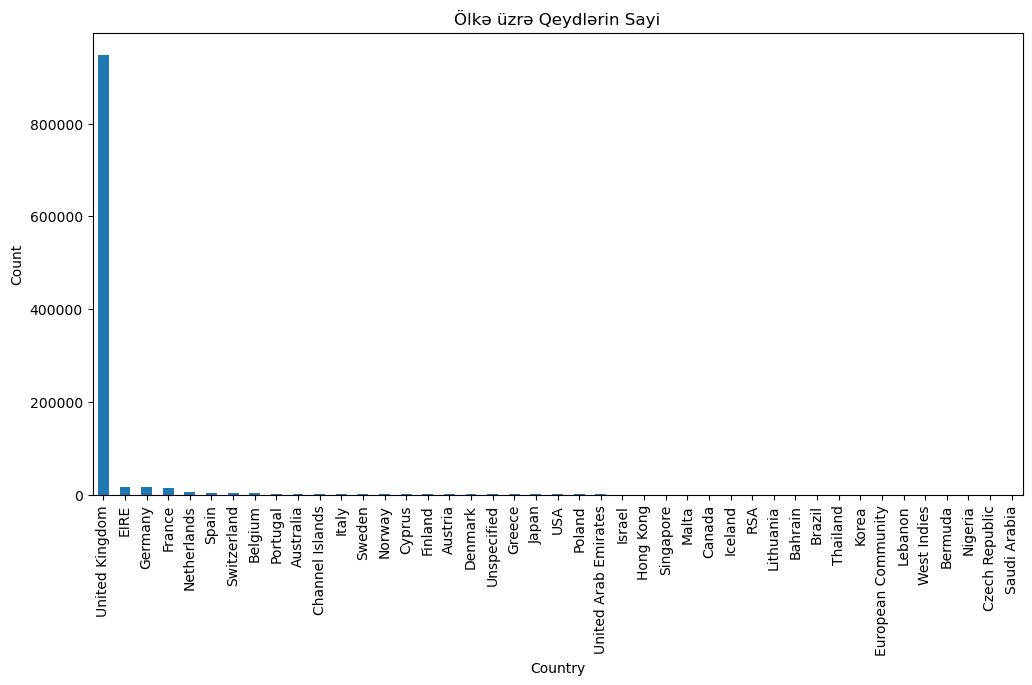

In [24]:
# ölkelerin sayını hesaplama ve grafik gosterme
country_counts = df['Country'].value_counts()
plt.figure(figsize=(12, 6))
country_counts.plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Ölkə üzrə Qeydlərin Sayi')
plt.show()

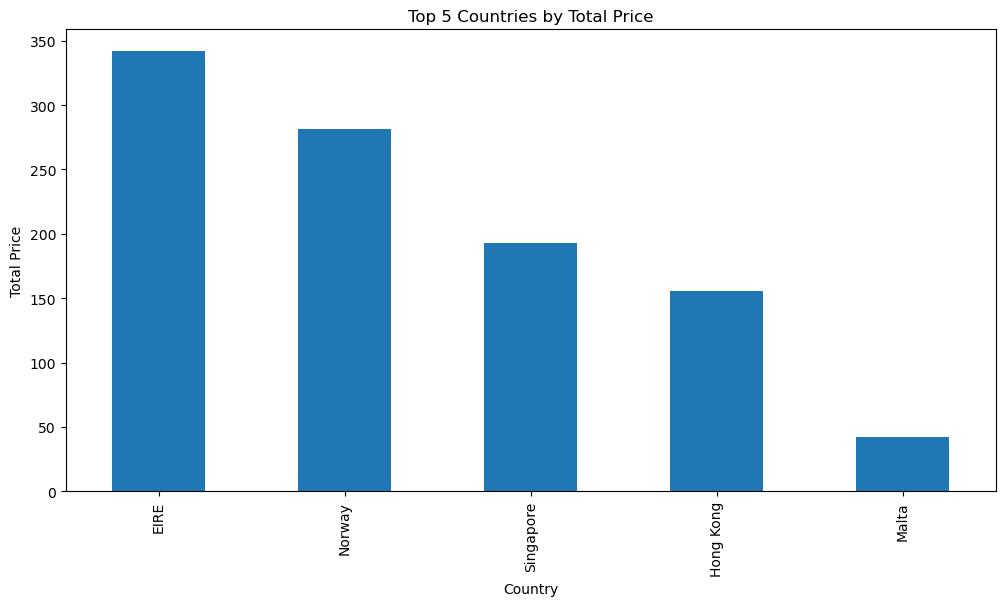

In [25]:
# son 5 ölkenin toplam priceni hesaplama ve grafik
top_countries = df.groupby('Country')['Price'].sum().nlargest(5)
plt.figure(figsize=(12, 6))
top_countries.plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Total Price')
plt.title('Top 5 Countries by Total Price')
plt.show()


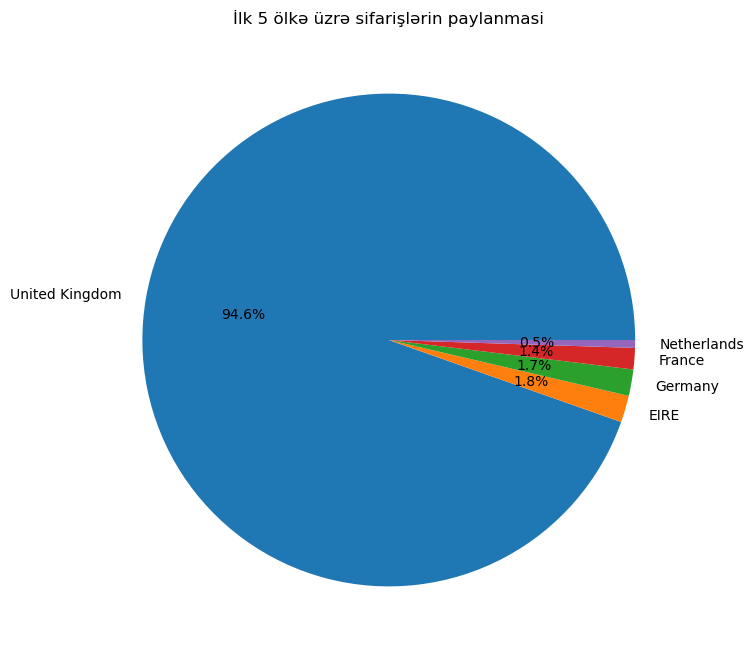

In [26]:
# ölkelerin sifariş sayılarını hesablama ve pie chart grafiki 
country_order_count = df['Country'].value_counts().sort_values(ascending=False)
top_5_ölke = country_order_count.head(5)
plt.figure(figsize=(8, 8))
plt.pie(top_5_ölke, labels=top_5_ölke.index, autopct='%1.1f%%')
plt.title('İlk 5 ölkə üzrə sifarişlərin paylanmasi')
plt.show()


In [27]:
df.head()

,Invoice,StockCode,Quantity,InvoiceDate,Price,Country
0,489434,85048,0.011934,2009-12-01 07:45:00,0.018620,United Kingdom
1,489434,79323P,0.011934,2009-12-01 07:45:00,0.017002,United Kingdom
2,489434,79323W,0.011934,2009-12-01 07:45:00,0.017002,United Kingdom
3,489434,22041,0.220381,2009-12-01 07:45:00,-0.020634,United Kingdom
4,489434,21232,0.081417,2009-12-01 07:45:00,-0.027514,United Kingdom


In [28]:
#'InvoiceDate' sütununu time series indeksi olaraq 
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.set_index('InvoiceDate', inplace=True)


In [29]:
#yeni sutun yaradiriq
df['TotalPrice'] = df['Quantity'] * df['Price']

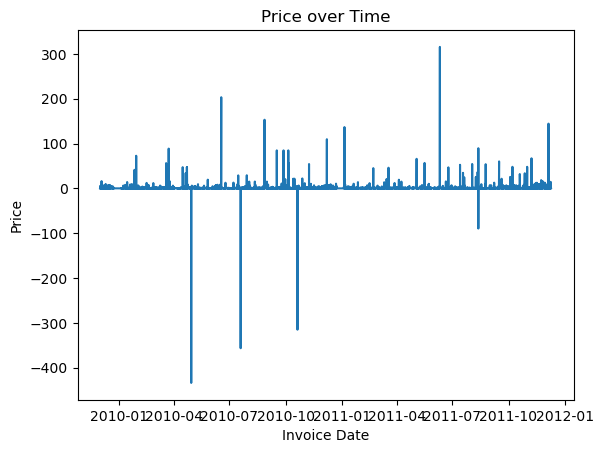

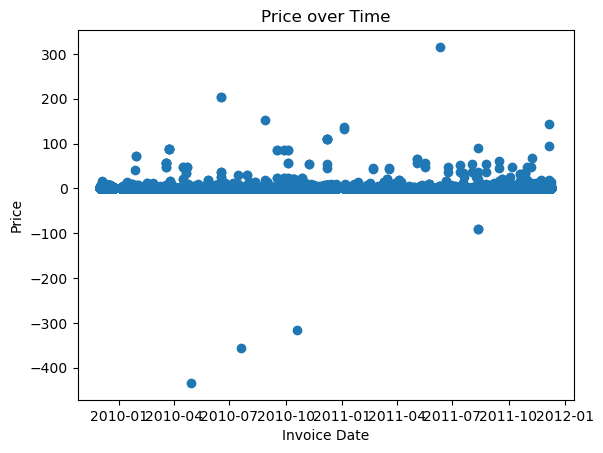

In [30]:
import matplotlib.pyplot as plt
plt.plot(df.index, df['Price'])
plt.xlabel('Invoice Date')
plt.ylabel('Price')
plt.title('Price over Time')
plt.show()

plt.scatter(df.index, df['Price'])
plt.xlabel('Invoice Date')
plt.ylabel('Price')
plt.title('Price over Time')
plt.show()


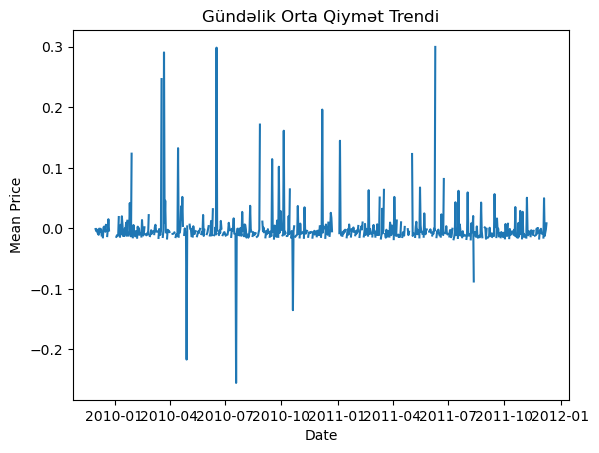

In [31]:
# Günlük ortalama deyerler ve Trend qrafiki
df_daily_mean = df['Price'].resample('D').mean()
plt.plot(df_daily_mean.index, df_daily_mean)
plt.xlabel('Date')
plt.ylabel('Mean Price')
plt.title('Gündəlik Orta Qiymət Trendi')
plt.show()


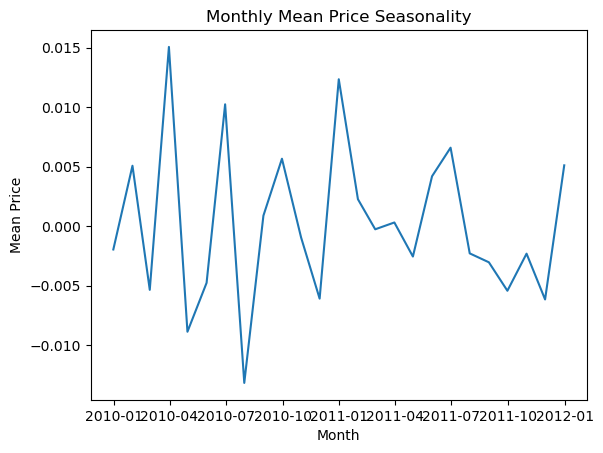

In [32]:
# Aylıq ortalama deyerler
df_monthly_mean = df['Price'].resample('M').mean()
plt.plot(df_monthly_mean.index, df_monthly_mean)
plt.xlabel('Month')
plt.ylabel('Mean Price')
plt.title('Monthly Mean Price Seasonality')
plt.show()


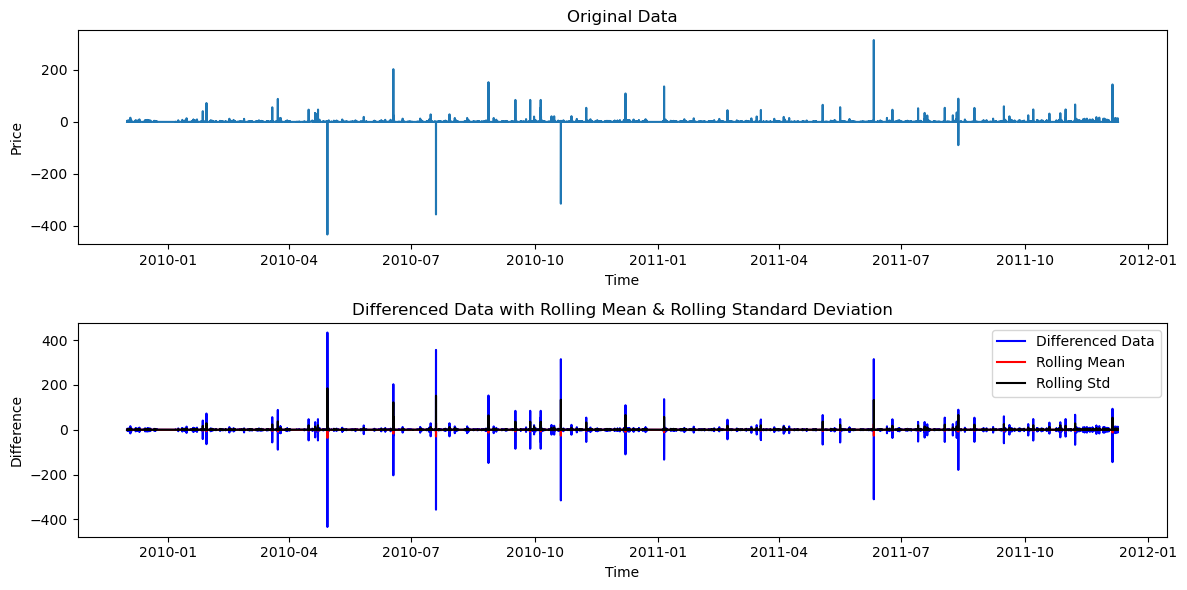

In [33]:
# Differencing (Ferq alma)
diff_price = df['Price'].diff().dropna()

# Rolling Mean ve Standard Deviation
rolling_mean = diff_price.rolling(window=12).mean()
rolling_std = diff_price.rolling(window=12).std()

# Real data, Ferq ve ortalama ve standart sapma görselleştirme
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(df['Price'])
plt.title('Original Data')
plt.xlabel('Time')
plt.ylabel('Price')

plt.subplot(2, 1, 2)
plt.plot(diff_price, color='blue', label='Differenced Data')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.title('Differenced Data with Rolling Mean & Rolling Standard Deviation')
plt.xlabel('Time')
plt.ylabel('Difference')
plt.legend()

plt.tight_layout()
plt.show()


In [34]:
# Statistik ölçülər
print('Mean Price:', df['Price'].mean())
print('Standard Deviation:', df['Price'].std())
print('Min Price:', df['Price'].min())
print('Max Price:', df['Price'].max())


Mean Price: -0.00028656254961374354
Standard Deviation: 0.9906488786290241
Min Price: -433.81390190051667
Max Price: 315.3735671820476


In [35]:
diff_price

InvoiceDate
2009-12-01 07:45:00   -0.001619
2009-12-01 07:45:00    0.000000
2009-12-01 07:45:00   -0.037636
2009-12-01 07:45:00   -0.006880
2009-12-01 07:45:00    0.003237
                         ...   
2011-12-09 12:50:00    0.010117
2011-12-09 12:50:00    0.016592
2011-12-09 12:50:00    0.000000
2011-12-09 12:50:00    0.006475
2011-12-09 12:50:00    0.105623
Name: Price, Length: 1033033, dtype: float64

In [36]:
# ADF TEST

result = adfuller(diff_price[-50000:])
print('ADF Statistik:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t', key, ':', value)

ADF Statistik: -50.5205301367779
p-value: 0.0
Critical Values:
	 1% : -3.430480944618592
	 5% : -2.8615978748306916
	 10% : -2.566800804858541


c:\Users\railm\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


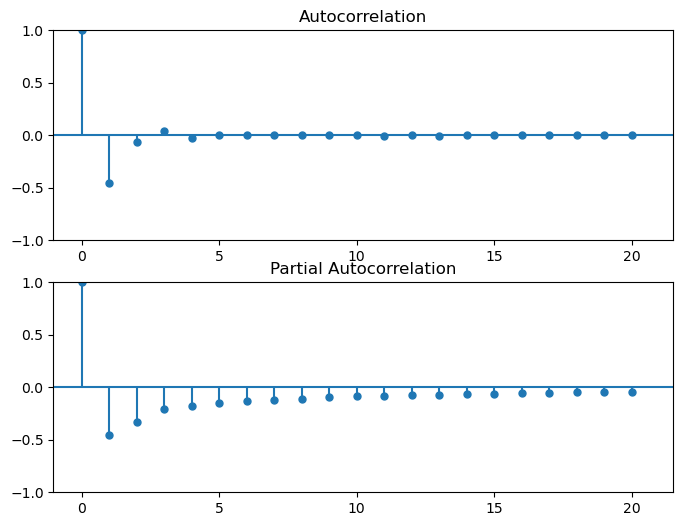

In [37]:
# ACF ve PACF grafikleri
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
plot_acf(diff_price, ax=ax[0], lags=20)
plot_pacf(diff_price, ax=ax[1], lags=20)
plt.show()

In [38]:
from sklearn.model_selection import train_test_split
train_size = int(len(diff_price) * 0.8)
# Train ve Test
train_data = diff_price[:train_size]
test_data = diff_price[train_size:]



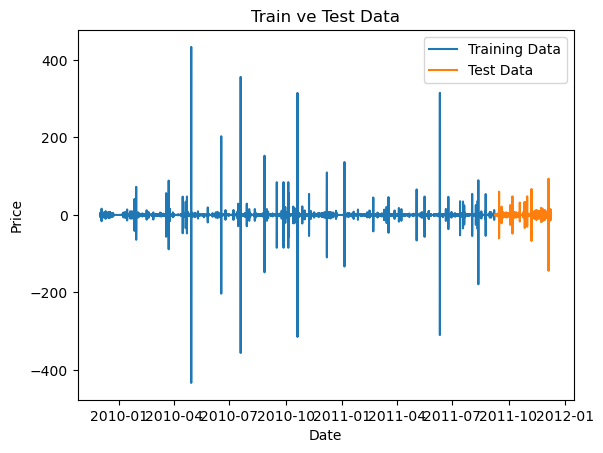

In [39]:
# Data viziuallasdirma
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Test Data')
plt.title('Train ve Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [44]:
from statsmodels.tsa.arima.model import ARIMA
p = 1
d = 1
q = 1
model = ARIMA(df['Price'], order=(p, d, q))
model_fit = model.fit()
forecast = model_fit.forecast(steps=10)


c:\Users\railm\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\railm\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\railm\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\railm\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [45]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:              1033034
Model:                 ARIMA(1, 1, 1)   Log Likelihood            -1449370.385
Date:                Mon, 03 Jul 2023   AIC                        2898746.770
Time:                        11:57:35   BIC                        2898782.314
Sample:                             0   HQIC                       2898756.539
                            - 1033034                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1139   2.62e-05   4350.649      0.000       0.114       0.114
ma.L1         -1.0000   2.25e-05  -4.45e+04      0.000      -1.000      -1.000
sigma2         0.9686   1.66e-05   5.83e+04      0.000       0.969       0.969
===================================================================================
Ljung-Box (L1) (Q):                   3.21   Jarque-Bera (JB):   277177749993218.91
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                           -83.32
Prob(H) (two-sided):                  0.00   Kurtosis:                     80249.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
start_date = '2010-05-01'
end_date = '2010-12-01'
predictions = model_fit.predict(start=start_date, end=end_date)


In [56]:
predictions

InvoiceDate
2010-05-02 10:22:00   -0.004723
2010-05-02 10:22:00   -0.000022
2010-05-02 10:22:00   -0.000022
2010-05-02 10:24:00   -0.000022
2010-05-02 10:24:00   -0.004723
                         ...   
2010-11-30 19:35:00   -0.007751
2010-11-30 19:35:00   -0.002358
2010-11-30 19:35:00   -0.008534
2010-11-30 19:35:00   -0.007751
2010-12-01 08:26:00   -0.002358
Name: predicted_mean, Length: 316749, dtype: float64

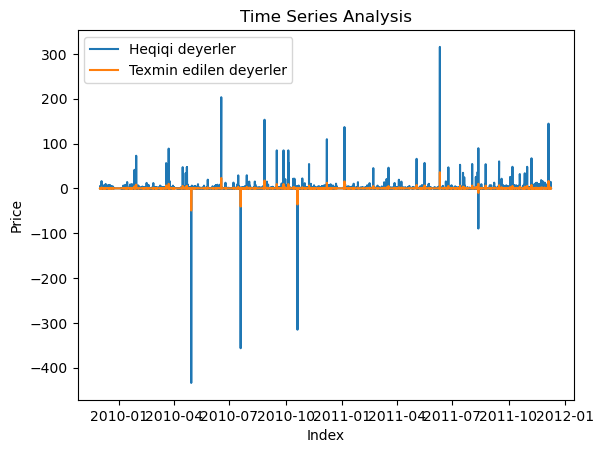

In [57]:
import matplotlib.pyplot as plt
# heqiqi deyerlerin time seriesi qrafiki
plt.plot(df.index, df['Price'], label='Heqiqi deyerler')
# Texmin edilen deyerlerin time series qrafiki
plt.plot(df.index, model_fit.predict(start=0, end=len(df)-1), label='Texmin edilen deyerler')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Time Series Analysis')
plt.legend()
plt.show()
